<a href="https://colab.research.google.com/github/jaytimbadia/UnWrapper/blob/master/ASRS_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.1MB 13.6MB/s 
     |████████████████████████████████| 1.5MB 13.9MB/s 
     |████████████████████████████████| 2.9MB 56.8MB/s 
     |████████████████████████████████| 890kB 60.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=38a3c90dc714cb69494cf604b3d856eb7946465eb8c364f6198dbcfd57018855
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import json
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import numpy as np
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Loading training and testing data json

with open('drive/MyDrive/data/train.json', 'r') as f:
    input_data = json.load(f)

with open('drive/MyDrive/data/test.json', 'r') as f1:
    testing_data = json.load(f1)

train_labels = pd.read_csv('drive/MyDrive/data/training_labels.csv', header=None)

train_data = pd.DataFrame(input_data)
test_data = pd.DataFrame(testing_data)

print('Number of data points in train text : ', train_data.shape[0])
print('Number of features in train text: ', train_data.shape[1])
print("Shape of train labels : ", train_labels.shape)

Number of data points in train text :  21519
Number of features in train text:  2
Shape of train labels :  (21519, 22)


In [4]:
# converting -1 label to 0 since we use sigmoid for multilabel instead of softmax and it lies in 0 to 1
train_labels = train_labels.applymap(lambda x: 0 if x<0 else 1)

In [5]:
stop_words = set(stopwords.words('english'))

def preprocess(total_text, use_stopwords=False):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        if use_stopwords:
            for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
                if not word in stop_words:
                    string += word + " "
        
            return string
        else:
            return total_text

train_data['cleaned_text'] = train_data.apply(lambda row: preprocess(row['text'], False), axis=1)
test_data['cleaned_text'] = test_data.apply(lambda row: preprocess(row['text'], False), axis=1)

In [6]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [7]:
train_text_list = train_data["cleaned_text"].values
test_text_list = test_data["cleaned_text"].values

In [16]:
# embedding size determination
text_length = []
for i in (train_text_list):
    if 100 < len(i.split()) < 700:
        text_length.append(len(i.split()))

print(np.mean(text_length))
plt.hist(text_length)

In [8]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [9]:
# truncating seq between 100 and 700 since others are less in numbers and can act as an outlier.
v= []
v_tst = []
filtered_labels = []
list_labels = train_labels.values
for i, j in zip(train_text_list, list_labels):
    if 100 < len(i.split()) < 700:
        v.append(i)
        filtered_labels.append(j)

for k in test_text_list:
    if 100 < len(k.split()) < 700:
        v_tst.append(k)        

In [10]:
# converting to dataframe
train_df = pd.DataFrame(v)
train_df = train_df.rename(columns={0: "raw_text"})

test_df = pd.DataFrame(v_tst)
test_df = test_df.rename(columns={0: "raw_text"})

In [11]:
train_text_list_ = train_df["raw_text"].values
test_text_list_ = test_df["raw_text"].values

In [12]:
train_input_ids = tokenize_inputs(train_text_list_, tokenizer, num_embeddings=250)
test_input_ids = tokenize_inputs(test_text_list_, tokenizer, num_embeddings=250)
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [15]:
# add input ids and attention masks to the dataframe
train_df["features"] = train_input_ids.tolist()
train_df["masks"] = train_attention_masks

test_df["features"] = test_input_ids.tolist()
test_df["masks"] = test_attention_masks

In [16]:
filtered_labels = np.array(filtered_labels)

In [17]:
train, valid, y_train, y_val = train_test_split(train_df, filtered_labels, test_size=0.2, random_state=42)

In [18]:
y_train.shape

(12692, 22)

In [19]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

Y_train = y_train.tolist()
Y_valid = y_val.tolist()

In [20]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [21]:
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

In [22]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss() # more stable than pure sigmoid
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [ ]:
num_epochs=3
import os
from tqdm import tqdm, trange
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_asrs.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")
# It takes an hour to train just 3 epochs with pretty workable loss

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.01204084963888503
Valid loss: 0.009389177575270686


Epoch:  33%|███▎      | 1/3 [17:12<34:24, 1032.14s/it]

Saving model at epoch 0 with validation loss of 0.009389177575270686


Train loss: 0.00883569953340322
Valid loss: 0.00870212494124759


Epoch:  67%|██████▋   | 2/3 [34:44<17:18, 1038.33s/it]

Saving model at epoch 1 with validation loss of 0.00870212494124759


Train loss: 0.00799812485804101
Valid loss: 0.008669619300257997


Epoch: 100%|██████████| 3/3 [52:16<00:00, 1045.59s/it]

Saving model at epoch 2 with validation loss of 0.008669619300257997




Text(0.5, 1.0, 'Loss vs Number of Epochs')

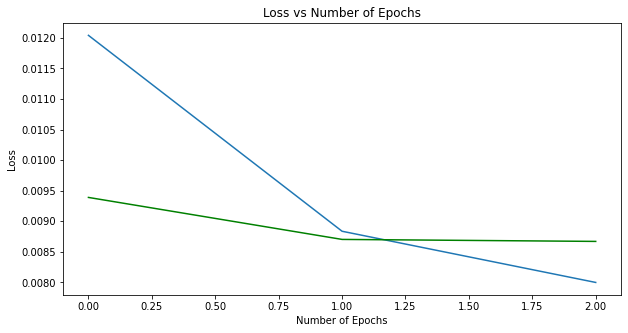

In [ ]:
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
test_df

,raw_text,features,masks
0,after takeoff on runway a loudnoise was hear c...,"[99, 182, 1372, 31, 11013, 24, 6037, 488, 2337...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,taxi off the parkingramp the brake system fail...,"[9507, 177, 18, 4169, 213, 1701, 18, 15878, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,just prior to depart of aircraft flight xxx ra...,"[125, 2114, 22, 16085, 20, 2005, 2115, 17, 272...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,selectivecalling from sfo airport commercialra...,"[14140, 12611, 56, 40, 17, 23, 6571, 2212, 147...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,had taxi out to runway for takeoff per prevail...,"[54, 9507, 78, 22, 11013, 28, 182, 1372, 451, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...
5264,i was attempt to make a short mile flight to r...,"[17, 150, 30, 1681, 22, 144, 24, 573, 5125, 21...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5265,this incident was a groundproximitywarningsyst...,"[52, 2510, 30, 24, 881, 3143, 6269, 98, 769, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5266,we encounter sever downdraft and microburst ca...,"[80, 6961, 17, 23, 3079, 151, 24827, 21, 4012,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5267,after a weather reroute and minute of hold wes...,"[99, 24, 2194, 17, 88, 26685, 21, 1901, 20, 85...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Genarate predictions on test dataset and saving

In [26]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
pred_probs = generate_predictions(model, test_df, 22, device="cuda", batch_size=32)
pred_probs

array([[8.69318284e-03, 8.13918859e-02, 4.42971755e-03, ...,
        7.02843489e-03, 7.82357994e-03, 1.13871720e-04],
       [1.29542202e-02, 3.94528091e-01, 1.83771420e-02, ...,
        6.47024775e-04, 2.73428694e-03, 2.18123270e-04],
       [8.12007859e-02, 9.83171821e-01, 6.89474808e-04, ...,
        1.07658643e-03, 9.51244205e-04, 1.00453673e-02],
       ...,
       [2.51499098e-03, 4.63218465e-02, 7.59470422e-05, ...,
        9.91543639e-04, 1.60006527e-02, 9.12326039e-04],
       [1.29880512e-03, 9.95421857e-02, 7.54158769e-04, ...,
        1.03548472e-03, 4.73000109e-03, 1.80090102e-03],
       [5.08053834e-03, 1.19083516e-01, 1.59518828e-03, ...,
        2.31891917e-03, 2.35915128e-02, 3.61341168e-03]])

In [ ]:
u = pd.DataFrame(pred_probs)
u = u.applymap(lambda x: 1 if x>=0.5 else 0)
u

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
5265,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0
5266,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5267,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
u['text'] = test_df['raw_text']

In [ ]:
u.to_csv(os.path.join(cwd, "drive/My Drive/Output/result.csv"))

Accuracy evaluation

In [13]:
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [24]:
import os
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_asrs.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [27]:
pred_probs = generate_predictions(model, train_df.head(5000), 22, device="cuda", batch_size=32)

In [30]:
# u = u.applymap(lambda x: 1 if x>=0.5 else 0)
tensor_filtered_labels = torch.Tensor(filtered_labels)
tensor_filtered_labels = tensor_filtered_labels[:5000]
tensor_filtered_labels.shape

torch.Size([5000, 22])

In [29]:
u_infer = pd.DataFrame(pred_probs)
u_infer = u_infer.applymap(lambda x: 1 if x>=0.5 else 0)
tensor_infer_pred = torch.Tensor(u_infer.values)
tensor_infer_pred.shape

torch.Size([5000, 22])

In [33]:
perf_sum = (tensor_filtered_labels == tensor_infer_pred).sum()
accuracy = (perf_sum / (tensor_infer_pred.shape[0] * tensor_infer_pred.shape[1]) ) * 100
print('Accuracy evaluated gives : {}'.format(accuracy.item()))

Accuracy evaluated gives : 95.24000549316406
